In [1]:
!pip install pyarrow

!pip uninstall scikit-learn -y

!pip install -U scikit-learn==1.5

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.9 MB/s eta 0:00:00


Dataset Overview and Cleaning

In [2]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from tensorflow.keras.callbacks import ModelCheckpoint

## HELPER FUNCS

In [3]:
from google.colab import drive
drive.mount('/content/drive')
processed_data_path = "/content/drive/MyDrive/yellow_processed_05.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def analyze_borough_trips(df):
    # Create pivot tables for average fare and distance
    avg_fare_pivot = pd.pivot_table(
        df,
        values='fare_amount',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )

    avg_distance_pivot = pd.pivot_table(
        df,
        values='trip_distance',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot heatmap for fares
    sns.heatmap(avg_fare_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('Average Fare Amount by Borough Routes')

    # Plot heatmap for distances
    sns.heatmap(avg_distance_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Average Trip Distance by Borough Routes')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary of trips between boroughs:")
    borough_counts = df.groupby(['Borough_pu', 'Borough_do']).size().reset_index()
    borough_counts.columns = ['Pickup Borough', 'Dropoff Borough', 'Number of Trips']
    print(borough_counts.sort_values('Number of Trips', ascending=False))

# 2. Box plots for fare distribution by borough pairs
def plot_fare_distributions(df):
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='Borough_pu', y='fare_amount', hue='Borough_do', data=df)
    plt.title('Fare Distribution by Borough Routes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Scatter plot of distance vs fare, colored by borough pairs
def plot_distance_vs_fare(df):
    plt.figure(figsize=(12, 8))
    for (pu, do), group in df.groupby(['Borough_pu', 'Borough_do']):
        plt.scatter(group['trip_distance'], group['fare_amount'],
                   label=f'{pu} to {do}', alpha=0.6)

    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Fare Amount ($)')
    plt.title('Trip Distance vs Fare Amount by Borough Routes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## DATA PULLS

In [ ]:
# Import the updated DataLoader class
sys.path.append(str(Path("../src").resolve()))
from data.data_loader import DataLoader

# Define file paths
data_path = "../data/raw/yellow_tripdata_2022-05.parquet"
output_path = "../data/processed/cleaned_yellow_tripdata_2022-05.parquet"

# Initialize the DataLoader
loader = DataLoader(data_path, output_path)

# Preprocess the data (this step generates the cleaned data file)
loader.preprocess()

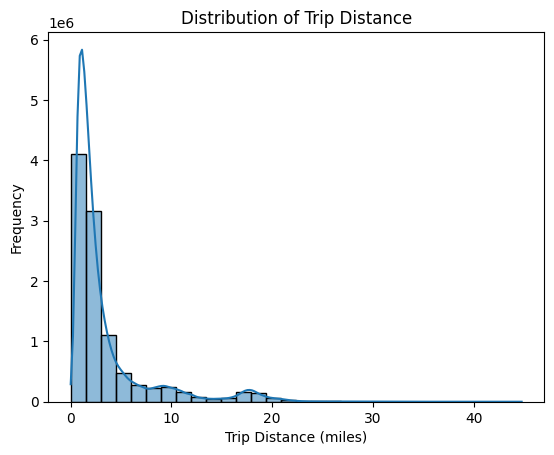

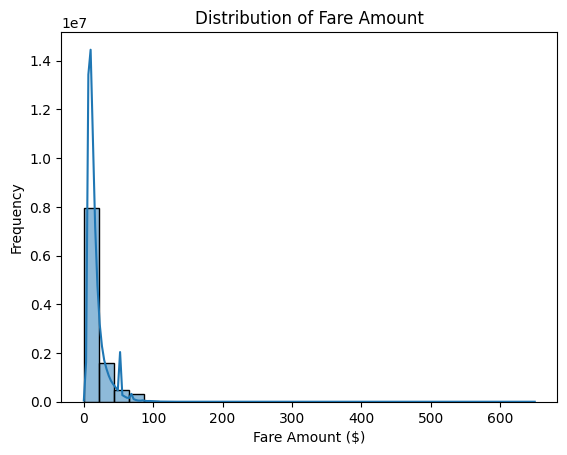

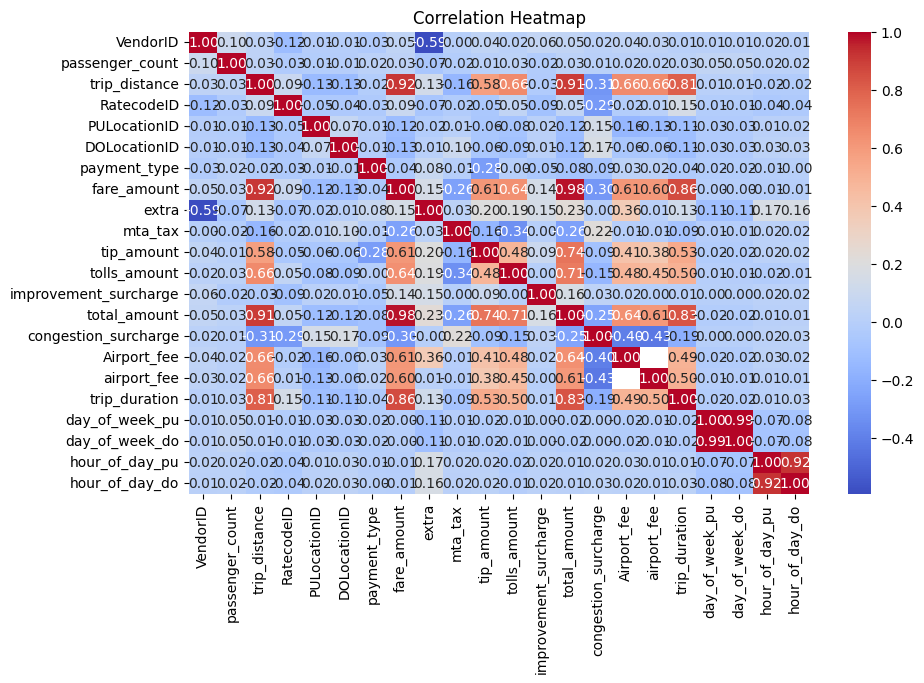

In [16]:

# Load the preprocessed data
processed_data_path = "/content/drive/MyDrive/yellow_processed_05.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

# Visualize the data
# Distribution of trip distance
sns.histplot(cleaned_df['trip_distance'], kde=True, bins=30)
plt.title("Distribution of Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

# Distribution of fare amount
if 'fare_amount' in cleaned_df.columns:
    sns.histplot(cleaned_df['fare_amount'], kde=True, bins=30)
    plt.title("Distribution of Fare Amount")
    plt.xlabel("Fare Amount ($)")
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap
numeric_df = cleaned_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



In [18]:
cleaned_df['fare_amount'].describe()

,fare_amount
count,1.036978e+07
mean,1.789875e+01
std,1.510588e+01
min,1.000000e-02
25%,8.600000e+00
50%,1.280000e+01
75%,2.050000e+01
max,6.500000e+02


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

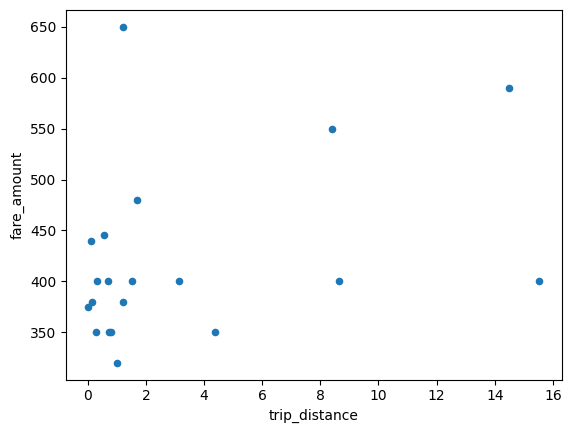

In [19]:
three_std_deviations = 1.465398e+01 + 3 * 9.641945e+01
mask_above_three_std_deviations = cleaned_df['fare_amount'] > three_std_deviations
below_crazy_fare_amount = cleaned_df['fare_amount'] < 50000

cleaned_df[mask_above_three_std_deviations & below_crazy_fare_amount].plot.scatter(x='trip_distance', y='fare_amount')

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

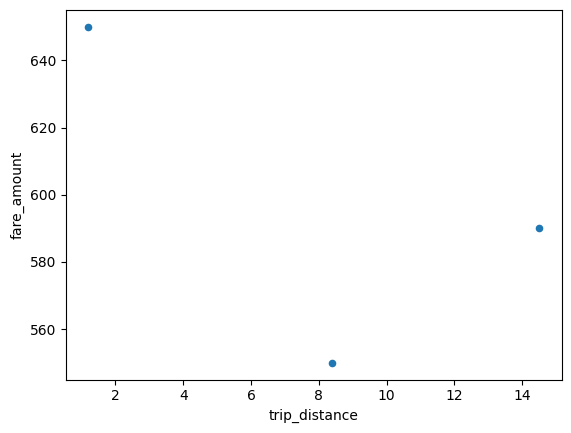

In [20]:
mask_fares_below_7000 = cleaned_df['fare_amount'] < 6000
mask_fares_above_6000 = cleaned_df['fare_amount'] > 500
mask_initiated_outside_nyc = cleaned_df['PULocationID'] == 265
mask_dropped_outside_nyc = cleaned_df['DOLocationID'] == 265
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000].plot.scatter(x='trip_distance', y='fare_amount')


In [21]:
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000][['Borough_pu', 'Borough_do', 'DOLocationID', 'trip_distance', 'fare_amount']].head()

,Borough_pu,Borough_do,DOLocationID,trip_distance,fare_amount
2231078,Manhattan,Manhattan,162,1.2,650.00
4966954,Manhattan,Queens,129,8.4,550.00
5808103,Queens,Queens,7,14.5,590.01


In [22]:
cleaned_df.size - cleaned_df[cleaned_df['PULocationID'] == 265].size


342202707

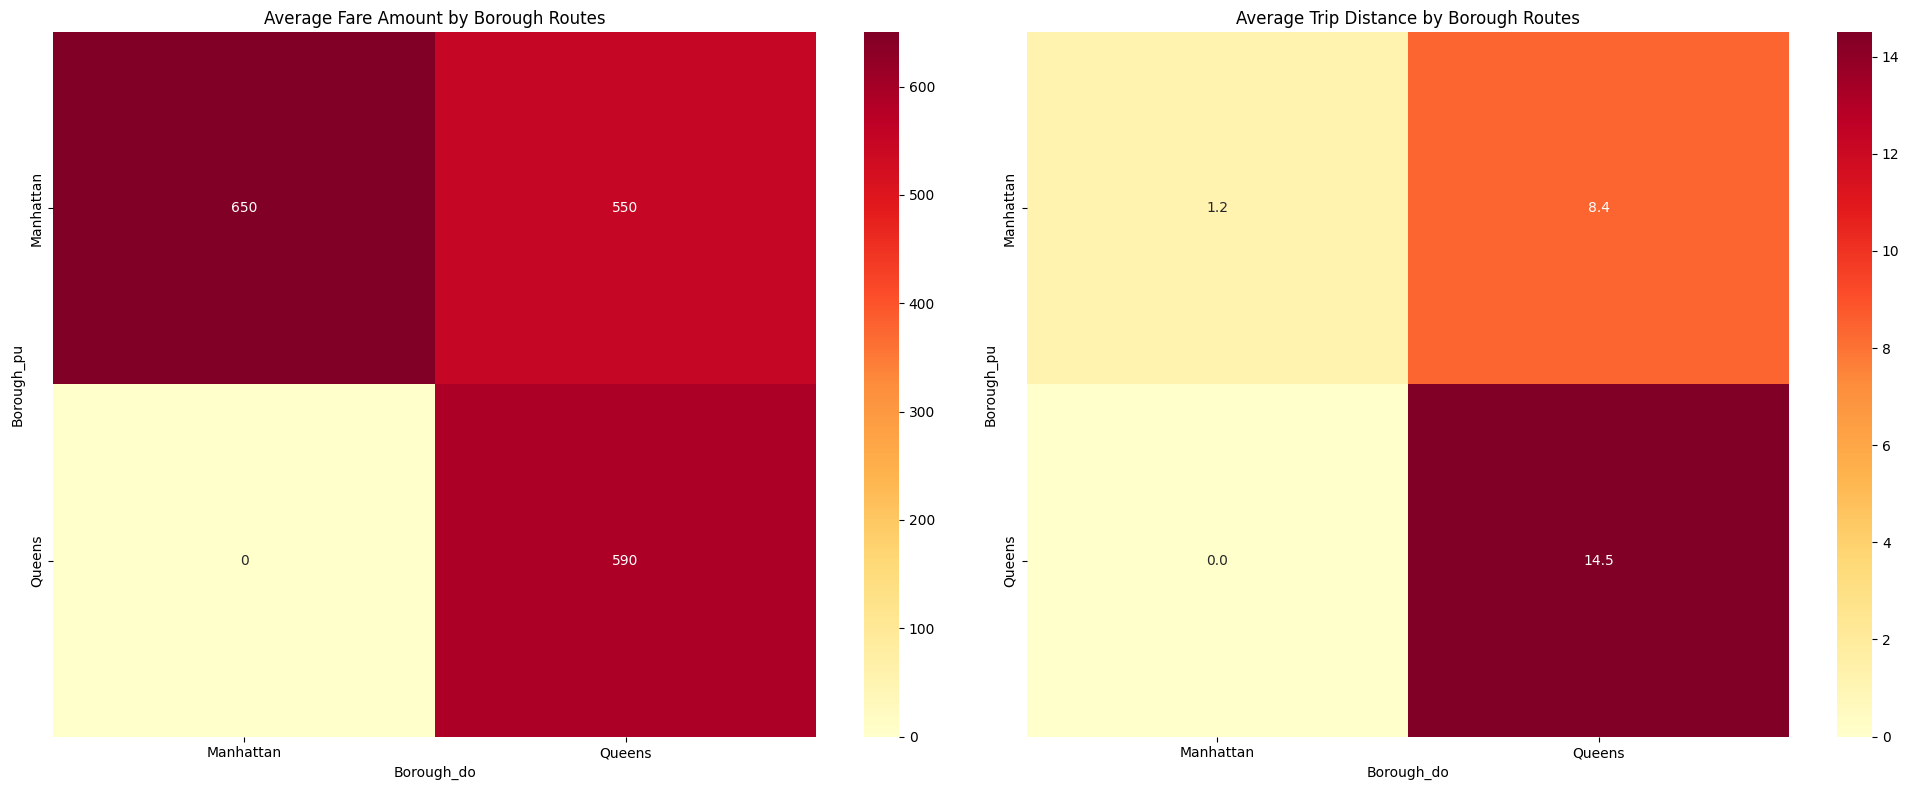


Summary of trips between boroughs:
  Pickup Borough Dropoff Borough  Number of Trips
0      Manhattan       Manhattan                1
1      Manhattan          Queens                1
2         Queens          Queens                1


In [23]:
filtered_df = cleaned_df[mask_fares_above_6000 & mask_fares_below_7000]
analyze_borough_trips(filtered_df)

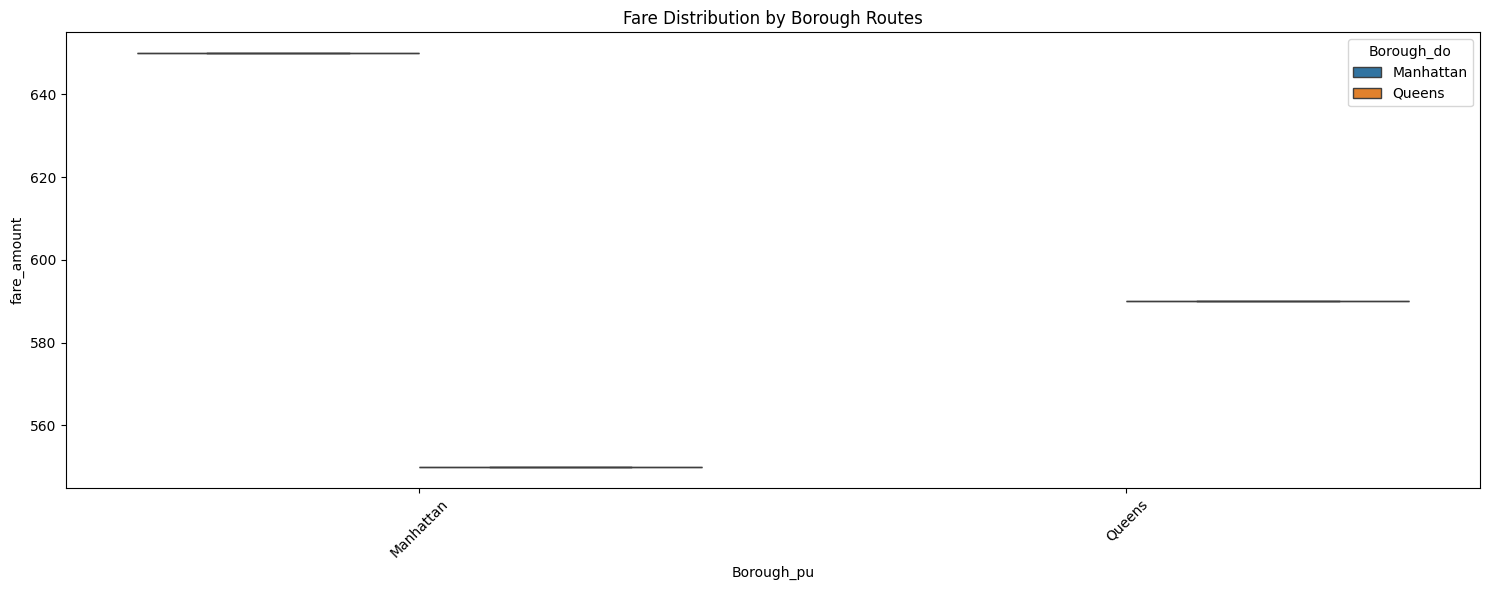

In [24]:
plot_fare_distributions(filtered_df)

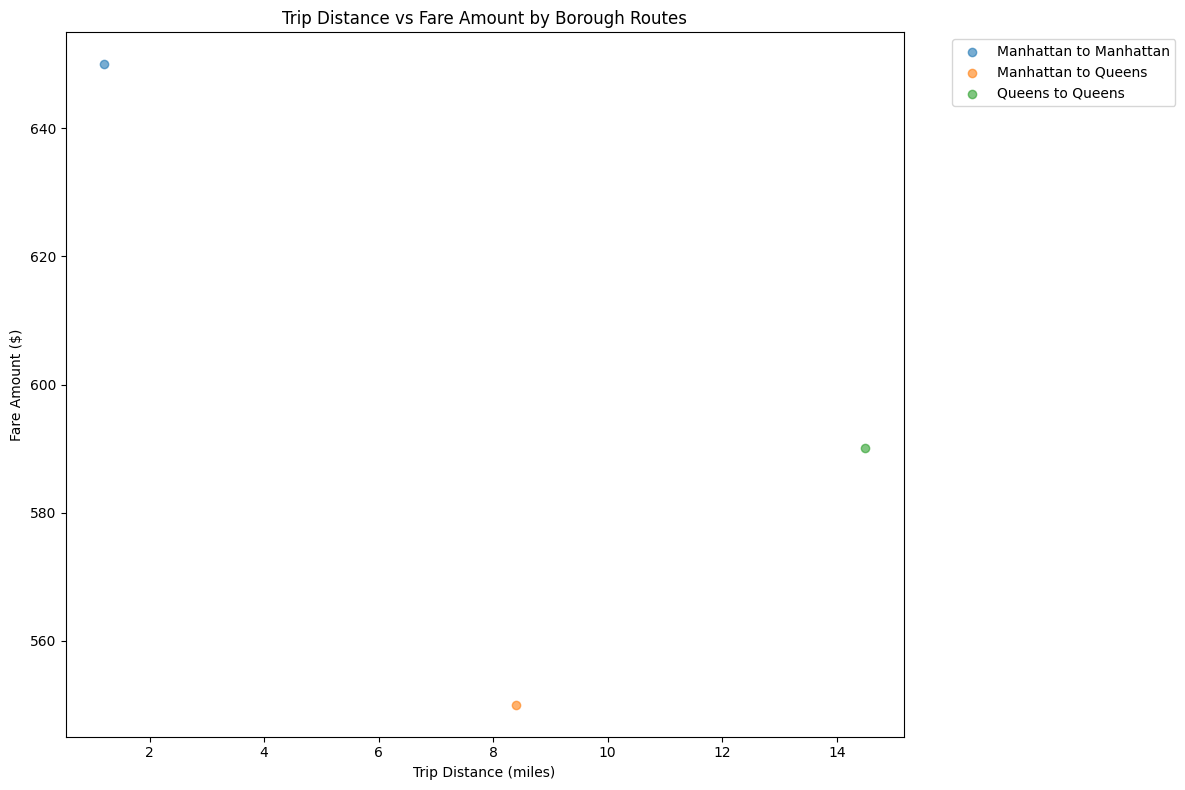

In [25]:
plot_distance_vs_fare(filtered_df)

In [26]:
short_trips = cleaned_df[cleaned_df['trip_distance'] <= 0.01]
short_trips_not_in_same_zone = short_trips[short_trips['PULocationID'] != short_trips['DOLocationID']]
short_trips_not_same_borough = short_trips_not_in_same_zone[short_trips_not_in_same_zone['Borough_do_zone'] != short_trips_not_in_same_zone['borough']]

short_trips_not_in_same_zone[['PULocationID', 'DOLocationID']].value_counts()

KeyError: 'Borough_do_zone'

In [27]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'airport_fee',
       'trip_duration', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'day_of_week_do', 'hour_of_day_pu', 'hour_of_day_do', 'time_of_day_pu',
       'time_of_day_do'],
      dtype='object')

In [ ]:
cleaned_df['Borough_do_zone'].value_counts()

Borough_do_zone
Manhattan        34672346
Queens            2109647
Brooklyn          1524470
Bronx              233924
Unknown            228124
EWR                106257
Staten Island        9666
Name: count, dtype: int64

# TRAIN THE MODEL

# we need to create a model using tensorflow to best predict the data, we'll use the cleaned_df for it

scikit-learn                       1.6.1


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.4 MB/s eta 0:00:00


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Linear Regression model

In [5]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'airport_fee',
       'trip_duration', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'day_of_week_do', 'hour_of_day_pu', 'hour_of_day_do', 'time_of_day_pu',
       'time_of_day_do'],
      dtype='object')

In [6]:
target = ['trip_duration', 'fare_amount']
features = ['trip_distance', 'store_and_fwd_flag', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'hour_of_day_pu', 'time_of_day_pu']

In [7]:
X = cleaned_df[features]
y = cleaned_df[target]

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Preprocessing pipeline
categorical_features = ['store_and_fwd_flag', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'time_of_day_pu']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu', ]

In [10]:
# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [87]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [13]:
y_train = y_train.values
y_test = y_test.values

In [14]:
mX_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['mae'])

In [18]:
checkpoint_cb = ModelCheckpoint(
    filepath='best_regression_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [ ]:
history = model.fit(X_train, y_train[:, 1],
                    validation_split=0.2,
                    epochs=20,
                    batch_size=1024,
                    callbacks=[checkpoint_cb])

In [19]:
# load model if saved
from tensorflow.keras.models import load_model
model = load_model('/content/linear_regression_FareAmount.keras')

# Accuracy of Linear Regression model

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test[:100,1], y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test[:100,1], y_pred)
r2 = r2_score(y_test[:,1], y_pred)

print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R^2:  {r2:.2f}")

64812/64812 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step


KeyError: 'key of type tuple not found and not a MultiIndex'

In [ ]:
def accuracy_within_t(y_true, y_pred, T=5.0):
    errors = np.abs(y_true - y_pred)
    return np.mean(errors <= T)

# Suppose y_test, y_pred are numpy arrays:
tolerance = 2.0
acc = accuracy_within_t(y_test[:,1], y_pred, tolerance)
print(f"Fraction of predictions within ${tolerance}: {acc:.2%}")

# XGBOOST with OneHotEncoder

In [16]:
categorical_features = ['store_and_fwd_flag', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'time_of_day_pu']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu', ]
all_features = categorical_features + numerical_features
target_col = 'fare_amount'

X = cleaned_df[all_features]
y = cleaned_df[target_col]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [48]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [50]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [53]:
cat_transform_name, cat_encoder, cat_cols = preprocessor.transformers_[0]
num_transform_name, num_scaler, num_cols = preprocessor.transformers_[1]

cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

# Combine them with the numeric column names
final_feature_names = np.concatenate([cat_feature_names, num_cols])

print("Final feature name array:\n", final_feature_names)

In [20]:
X_train_prep.shape

(8295823, 546)

### Main model training

In [16]:
from xgboost import XGBRegressor

# Create the model
xgb_model = XGBRegressor(
    n_estimators=100,        # number of trees
    max_depth=6,             # maximum depth of each tree
    learning_rate=0.1,       # shrinkage (eta)
    subsample=0.8,           # fraction of data for each tree
    colsample_bytree=0.8,    # fraction of features for each tree
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
)

In [17]:
xgb_model.fit(
    X_train_prep,
    y_train,
    eval_set=[(X_test_prep, y_test)],  # for early stopping
    verbose=True                  # prints training progress
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:11.69252
[1]	validation_0-rmse:10.84992
[2]	validation_0-rmse:10.11281
[3]	validation_0-rmse:9.47275
[4]	validation_0-rmse:8.91300
[5]	validation_0-rmse:8.42734
[6]	validation_0-rmse:8.11403
[7]	validation_0-rmse:7.85322
[8]	validation_0-rmse:7.63988
[9]	validation_0-rmse:7.45303
[10]	validation_0-rmse:7.16455
[11]	validation_0-rmse:6.92010
[12]	validation_0-rmse:6.70787
[13]	validation_0-rmse:6.52948
[14]	validation_0-rmse:6.37969
[15]	validation_0-rmse:6.24915
[16]	validation_0-rmse:6.14107
[17]	validation_0-rmse:6.05058
[18]	validation_0-rmse:5.96798
[19]	validation_0-rmse:5.92485
[20]	validation_0-rmse:5.86172
[21]	validation_0-rmse:5.82617
[22]	validation_0-rmse:5.77735
[23]	validation_0-rmse:5.73296
[24]	validation_0-rmse:5.69520
[25]	validation_0-rmse:5.66354
[26]	validation_0-rmse:5.63559
[27]	validation_0-rmse:5.60998
[28]	validation_0-rmse:5.58815
[29]	validation_0-rmse:5.57015
[30]	validation_0-rmse:5.55658
[31]	validation_0-rmse:5.53618
[32]	validation

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

In [18]:
# saving the model
xgb_model.save_model('xgb_model.json')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [19]:
y_pred = xgb_model.predict(X_test_prep)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:04:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


MAE:  3.499
MSE:  27.179
RMSE: 5.213
R^2:  0.828


### hyperparameter tunning

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [47]:
param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.1, 0.01],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

In [46]:
# Define XGBoost model for regression, using GPU
xgb_reg = xgb.XGBRegressor(
    tree_method='gpu_hist',   # Use GPU-accelerated tree building
    predictor='gpu_predictor',
    random_state=42
)

xgb_model_cpu = xgb.XGBRegressor(tree_method='hist', predictor='cpu_predictor')

In [44]:


# Combine into a scikit-learn Pipeline:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb_model_cpu)
])

In [25]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_mean_squared_error', 'r2', etc.
    verbose=2,       # Controls the amount of logging
    n_jobs=-1        # Use all CPU cores for parallelism
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:47:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['store_and_fwd_flag',
                                                                          'Borough_pu',
                                                                          'Zone_pu',
                                                                          'service_zone_pu',
                                                                          'Borough_do',
                                                                          'Zone_do',
                                                                          'service_zone_do',
                                                                          'time_of_day_pu']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['trip_distance',
                                                                          'day_of_week_pu',
                                                                          'hour_of_day_pu'])])),
                                       ('xgb',
                                        XG...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor='cpu_predictor', ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__learning_rate': [0.1, 0.01],
                         'xgb__max_depth': [4, 6],
                         'xgb__n_estimators': [100, 300],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [26]:
print("Best Score:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.predict(X_test)

Best Score: -3.09758033773894
Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 300, 'xgb__subsample': 1.0}


array([14.600942, 23.180311,  5.22742 , ..., 10.630331, 49.29061 ,
        9.414047], dtype=float32)

In [27]:
best_model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['store_and_fwd_flag', 'Borough_pu', 'Zone_pu',
                                   'service_zone_pu', 'Borough_do', 'Zone_do',
                                   'service_zone_do', 'time_of_day_pu']),
                                 ('num', StandardScaler(),
                                  ['trip_distance', 'day_of_week_pu',
                                   'hour_of_day_pu'])]),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot

In [28]:
best_model.named_steps['xgb'].save_model('gridsearch_xgb_fare.json')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:49:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [59]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

MAE:  3.364
RMSE: 5.024
R²:   0.841


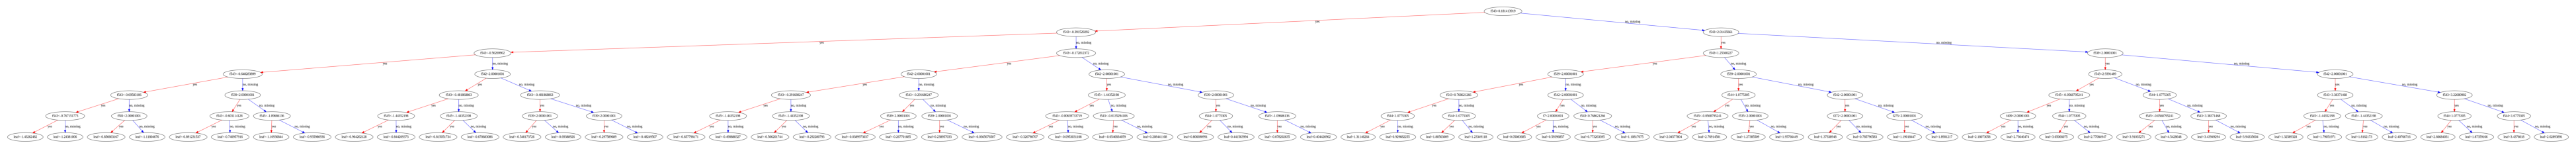

In [62]:
booster = best_model.named_steps['xgb'].get_booster()

xgb.plot_tree(booster, num_trees=0)
plt.show()

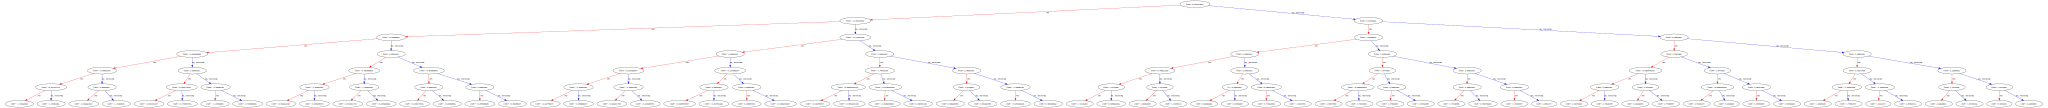

In [64]:
xgb.to_graphviz(booster, num_trees=0)


### SHAP

In [29]:
!pip install shap

In [30]:
import shap

In [37]:
explainer = shap.TreeExplainer(best_model.named_steps['xgb'])

X_sample = X_test_prep[:100].toarray()
shap_values = explainer.shap_values(X_sample)

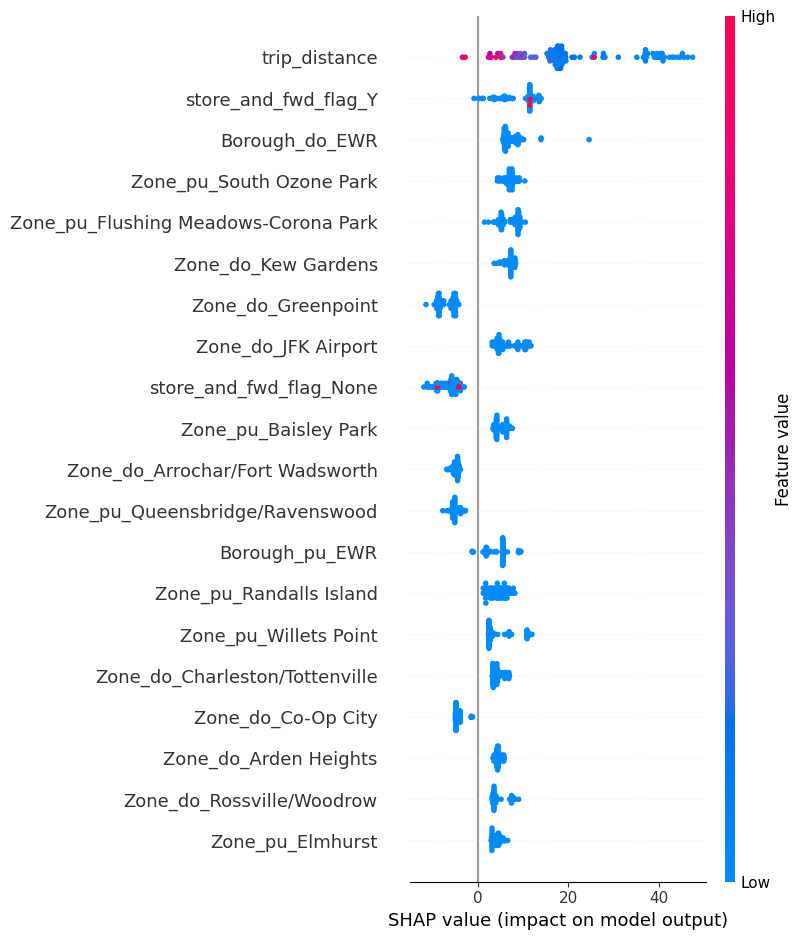

In [52]:
shap.summary_plot(shap_values, X_sample, feature_names=final_feature_names)

In [41]:
shap.initjs()

In [43]:
i = 0  # index of the sample
shap.force_plot(
    explainer.expected_value,
    shap_values[i,:],
    X_sample[i,:]
)

### Cross Validation training

In [28]:
import sklearn
sklearn.__version__

'1.5.0'

In [29]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [30]:
cv_xgboost_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

In [31]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(cv_xgboost_model, X_train_prep, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [33]:
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: -3.377 (0.008)


In [36]:
print(cv_xgboost_model.get_xgb_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None, 'predictor': 'gpu_predictor'}


# XGBOOST with Target Encoders

## GridSearch

In [4]:
! pip install category_encoders==2.7

In [10]:
import category_encoders as ce
from sklearn.model_selection import KFold, GridSearchCV

In [6]:
one_hot_features = ['store_and_fwd_flag', 'Borough_pu', 'service_zone_pu',
       'Borough_do', 'service_zone_do', 'time_of_day_pu']
categorical_features = ['Zone_pu', 'Zone_do']
numerical_features = ['trip_distance', 'day_of_week_pu', 'hour_of_day_pu']
all_features = categorical_features + numerical_features + one_hot_features

target_col = 'fare_amount'
#target_col = 'trip_duration'

X = cleaned_df[all_features]
y = cleaned_df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# for_one_hot_preprocessor = ColumnTransformer(
#     transformers=[
#         ('target_enc', ce.TargetEncoder(), categorical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_features),
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

xgb_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

target_encoder = ce.TargetEncoder(
    cols=categorical_features,
    smoothing=0.3,
    return_df=True
)

preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown='ignore'), one_hot_features),
    ("num_scaler", StandardScaler(), numerical_features)
], remainder='passthrough')

# 4) Assemble everything into a single Pipeline
model_pipeline = Pipeline([
    ("target_enc", target_encoder),
    ("col_transform", preprocessor),
    ("xgb", xgb_model)
])

In [11]:
param_grid = {
    "target_enc__smoothing": [0.3, 0.5, 0.7],
    "xgb__max_depth": [3, 6],
    "xgb__n_estimators": [50, 100, 200, 300],
    "xgb__learning_rate": [0.1, 0.01],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

from sklearn.model_selection import KFold

# We'll do a 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
